In [1]:
%matplotlib inline
%reload_ext Cython
from __future__ import print_function
import time
import pylab
import numpy as np
from numpy import int16, uint16, uint8, float16, log2

import cv2
from cv2 import cvtColor as convertColor, COLOR_BGR2GRAY, COLOR_GRAY2RGB,\
                resize, imread, imwrite

try:                  #nearest neighboor interpolation
  from cv2.cv import CV_INTER_NN, \
                     CV_CAP_PROP_FRAME_WIDTH, \
                     CV_CAP_PROP_FRAME_HEIGHT, \
                     CV_CAP_PROP_FPS, \
                     CV_LOAD_IMAGE_GRAYSCALE
except:
  from cv2 import INTER_NEAREST as CV_INTER_NN, \
                  CAP_PROP_FRAME_WIDTH as CV_CAP_PROP_FRAME_WIDTH, \
                  CAP_PROP_FRAME_HEIGHT as CV_CAP_PROP_FRAME_HEIGHT, \
                  CAP_PROP_FPS as CV_CAP_PROP_FPS, \
                  IMREAD_GRAYSCALE as CV_LOAD_IMAGE_GRAYSCALE

import inspect
import os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

import pyximport; pyximport.install()
#from pydvs.generate_spikes import *
from pydvs.generate_spikes import *

In [2]:
green = [0., 1., 0.]
red   = [1., 0., 0.]

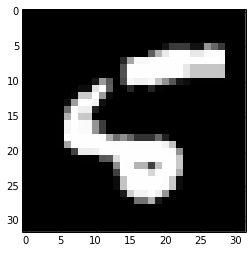

In [69]:
img_path = "./t10k-images-idx3-ubyte__idx_008__lbl_5_.png"
channels = 3
orig_w = 28
scl_w = 32
out_w = 32
fr = (out_w - scl_w)//2
to = fr + scl_w

num_cycles = 3
history_weight = 1.
cam_fps = 60
frame_time_ms = int(1000./cam_fps)
speed = 1. #pix/sec
max_val = 255
ref_init = int16(0*max_val)
min_thr = int16(0.05*max_val)
max_thr = min_thr*11
#thr_init = (max_thr - min_thr)//2
thr_init = min_thr
thr_delta_dn = min_thr
thr_delta_up = thr_delta_dn*2
out_img = np.zeros((out_w, out_w), dtype=int16)
ref_img = ref_init*np.ones((out_w, out_w), dtype=int16)
dif_img = np.zeros((out_w, out_w), dtype=int16)
abs_dif = np.zeros((out_w, out_w), dtype=int16)
spikes  = np.zeros((out_w, out_w), dtype=int16)
adp_thr = thr_init*np.ones((out_w, out_w), dtype=int16)
ctr_img = np.zeros((out_w, out_w), dtype=int16)
orig_img = imread(img_path, CV_LOAD_IMAGE_GRAYSCALE)
spk_img = np.zeros((out_w, out_w, channels))
if scl_w != orig_w:
    orig_img = resize(orig_img, (scl_w, scl_w), interpolation=CV_INTER_NN)

ctr_img[fr:to, fr:to] = orig_img

ref_img1 = ref_init*np.ones((out_w, out_w), dtype=int16)
dif_img1 = np.zeros((out_w, out_w), dtype=int16)
abs_dif1 = np.zeros((out_w, out_w), dtype=int16)
spikes1  = np.zeros((out_w, out_w), dtype=int16)


pylab.figure()
pylab.imshow(ctr_img, cmap='Greys_r', interpolation='none')
pylab.show()


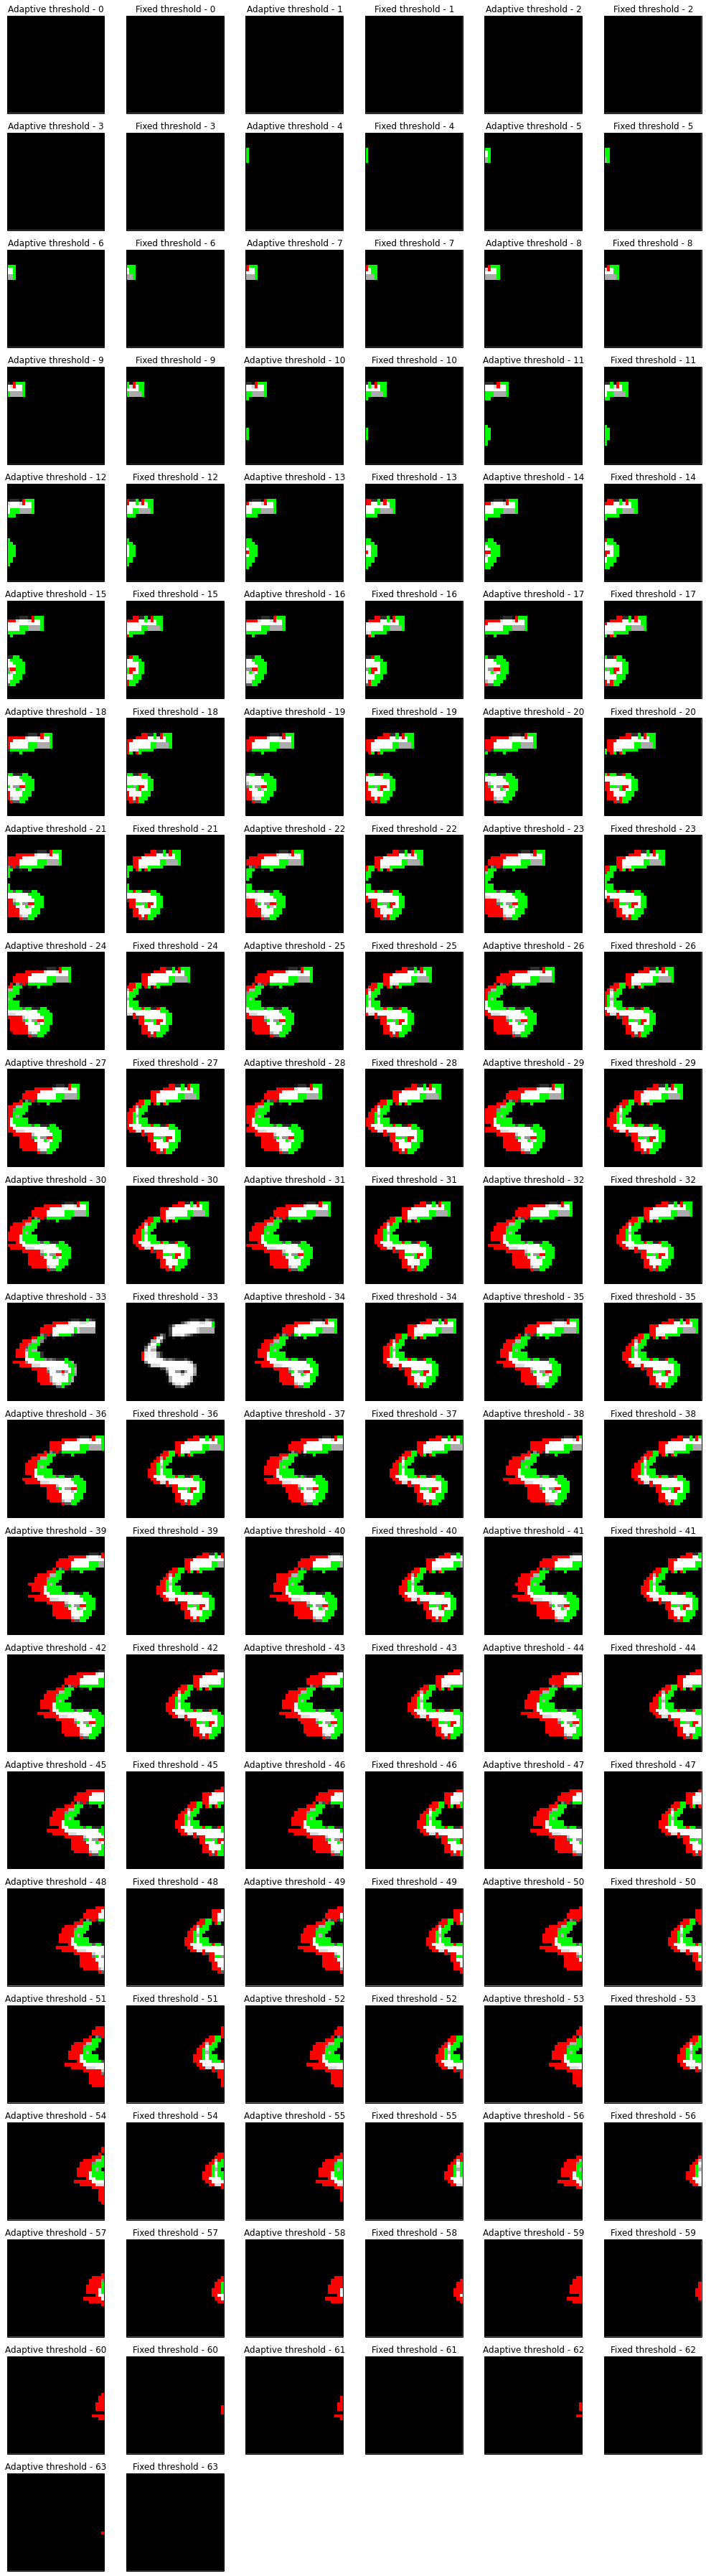

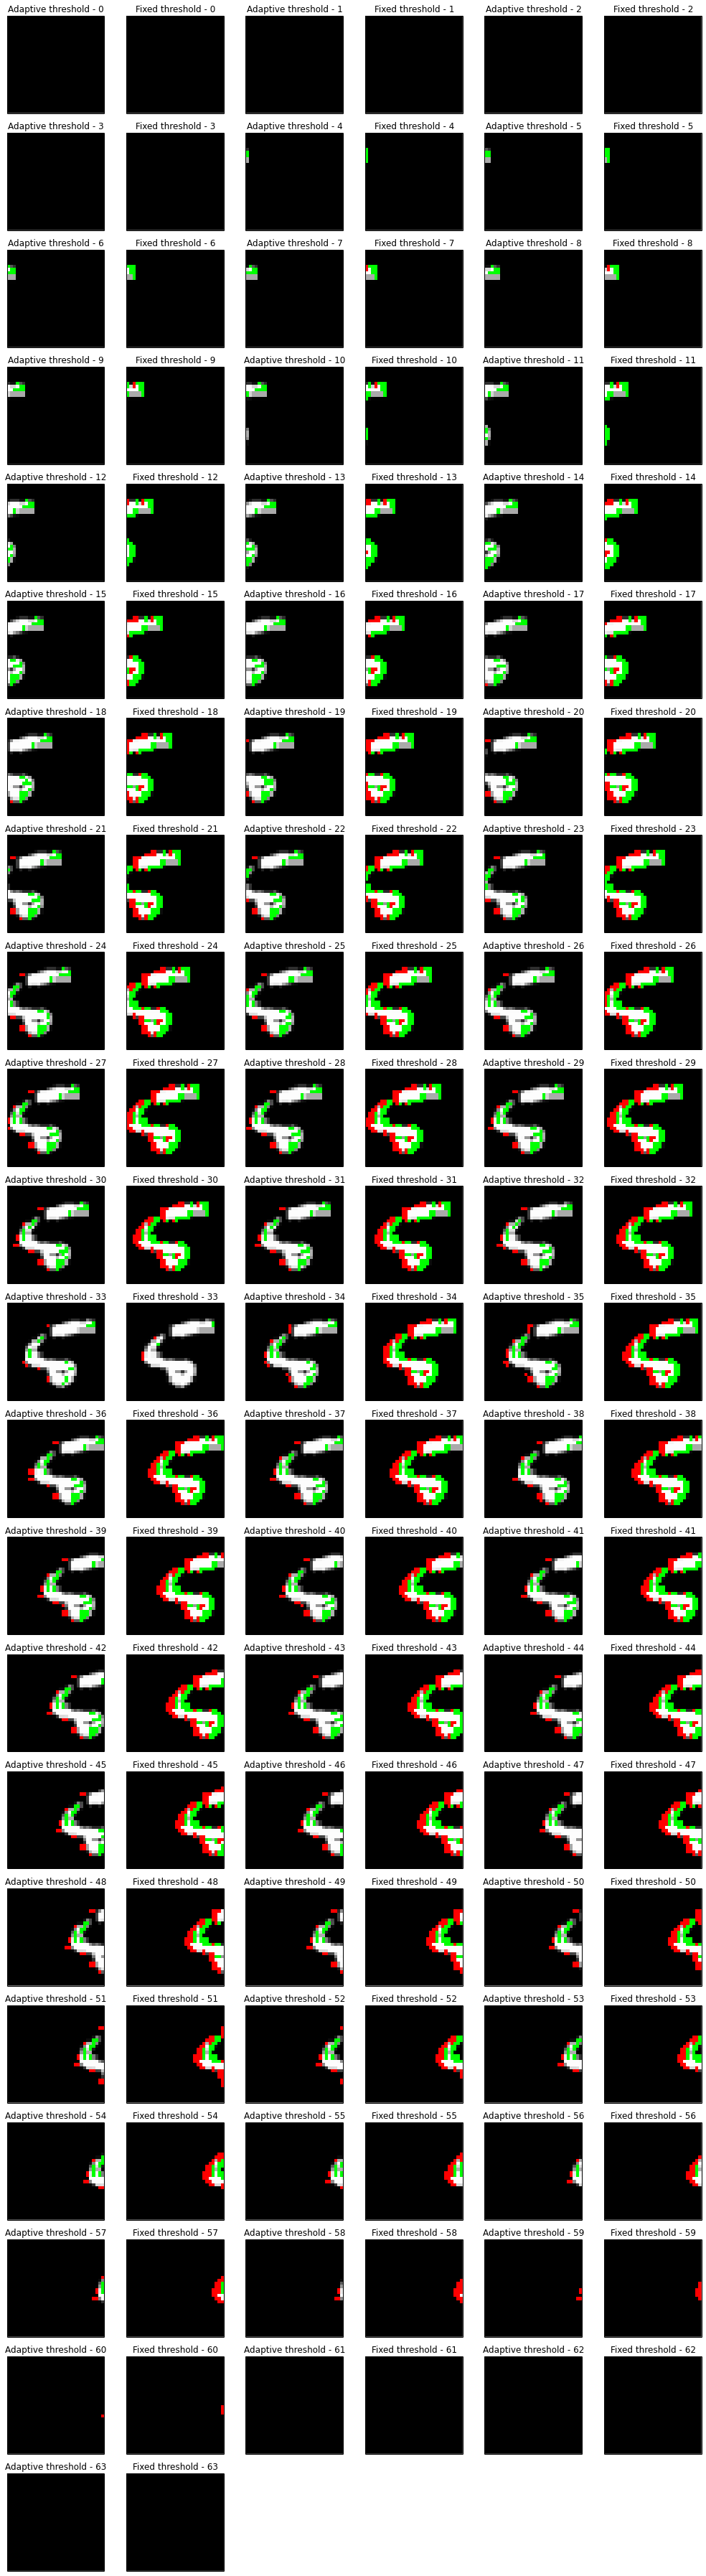

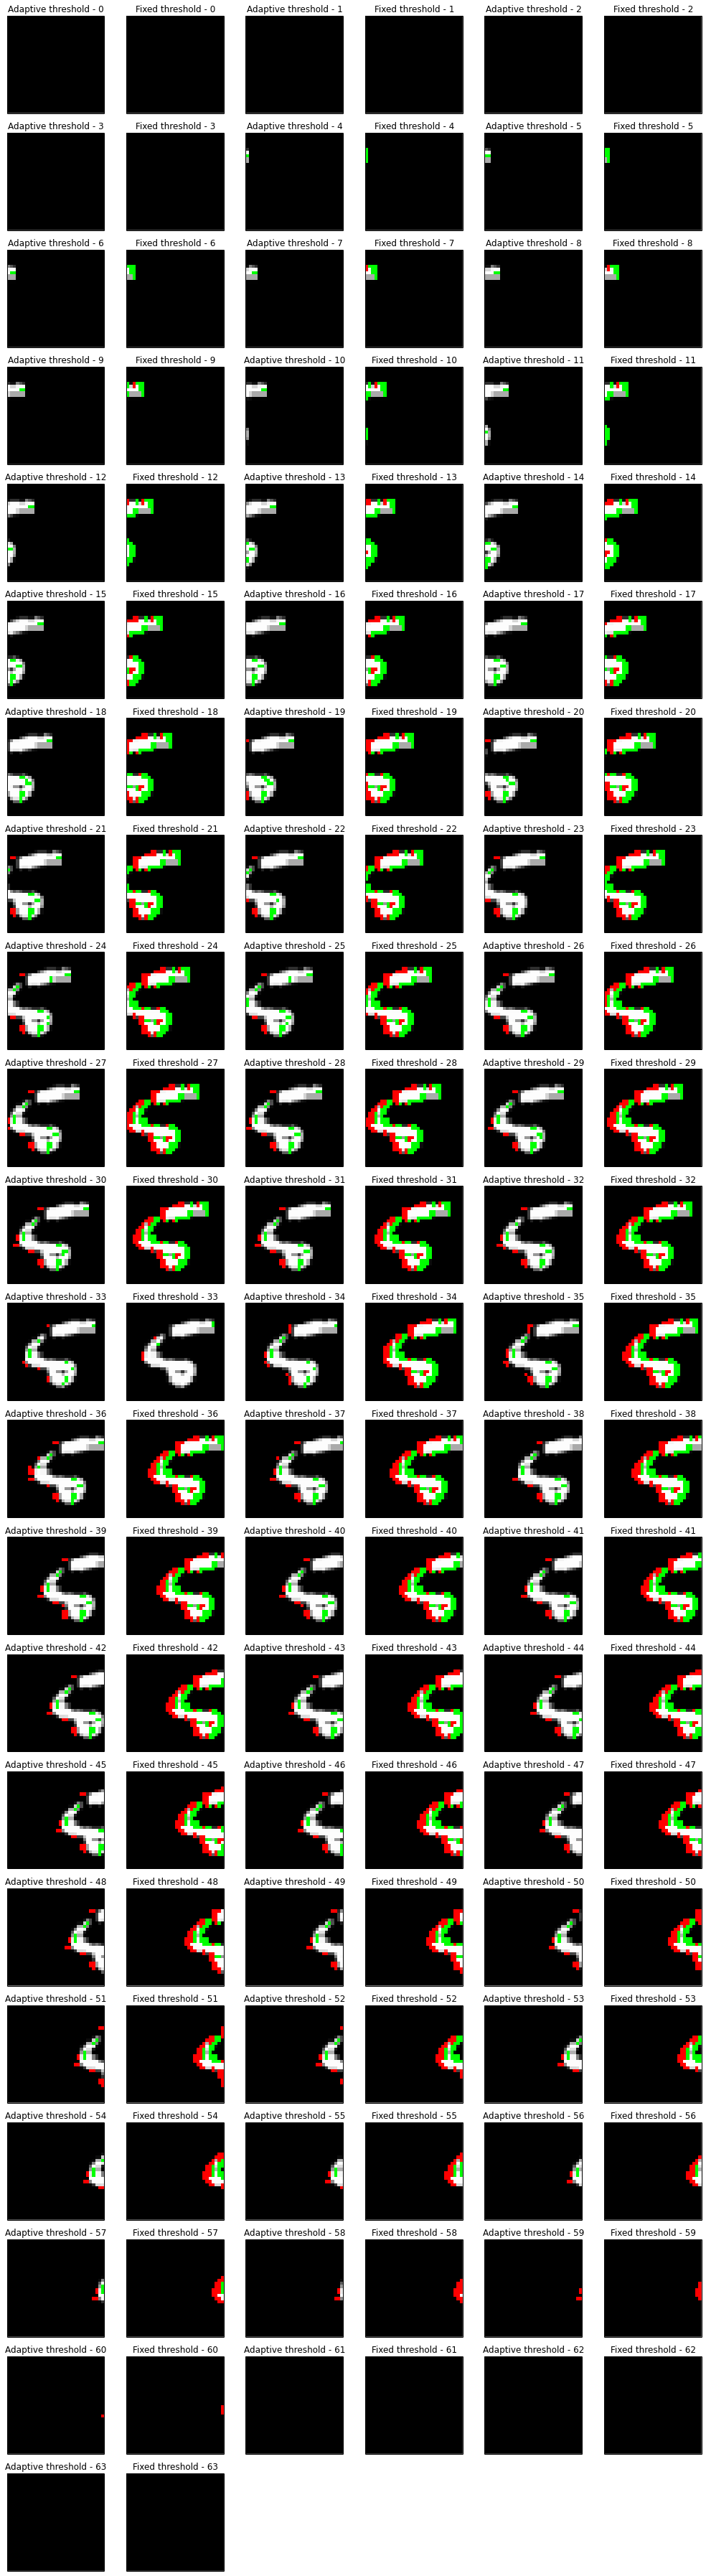

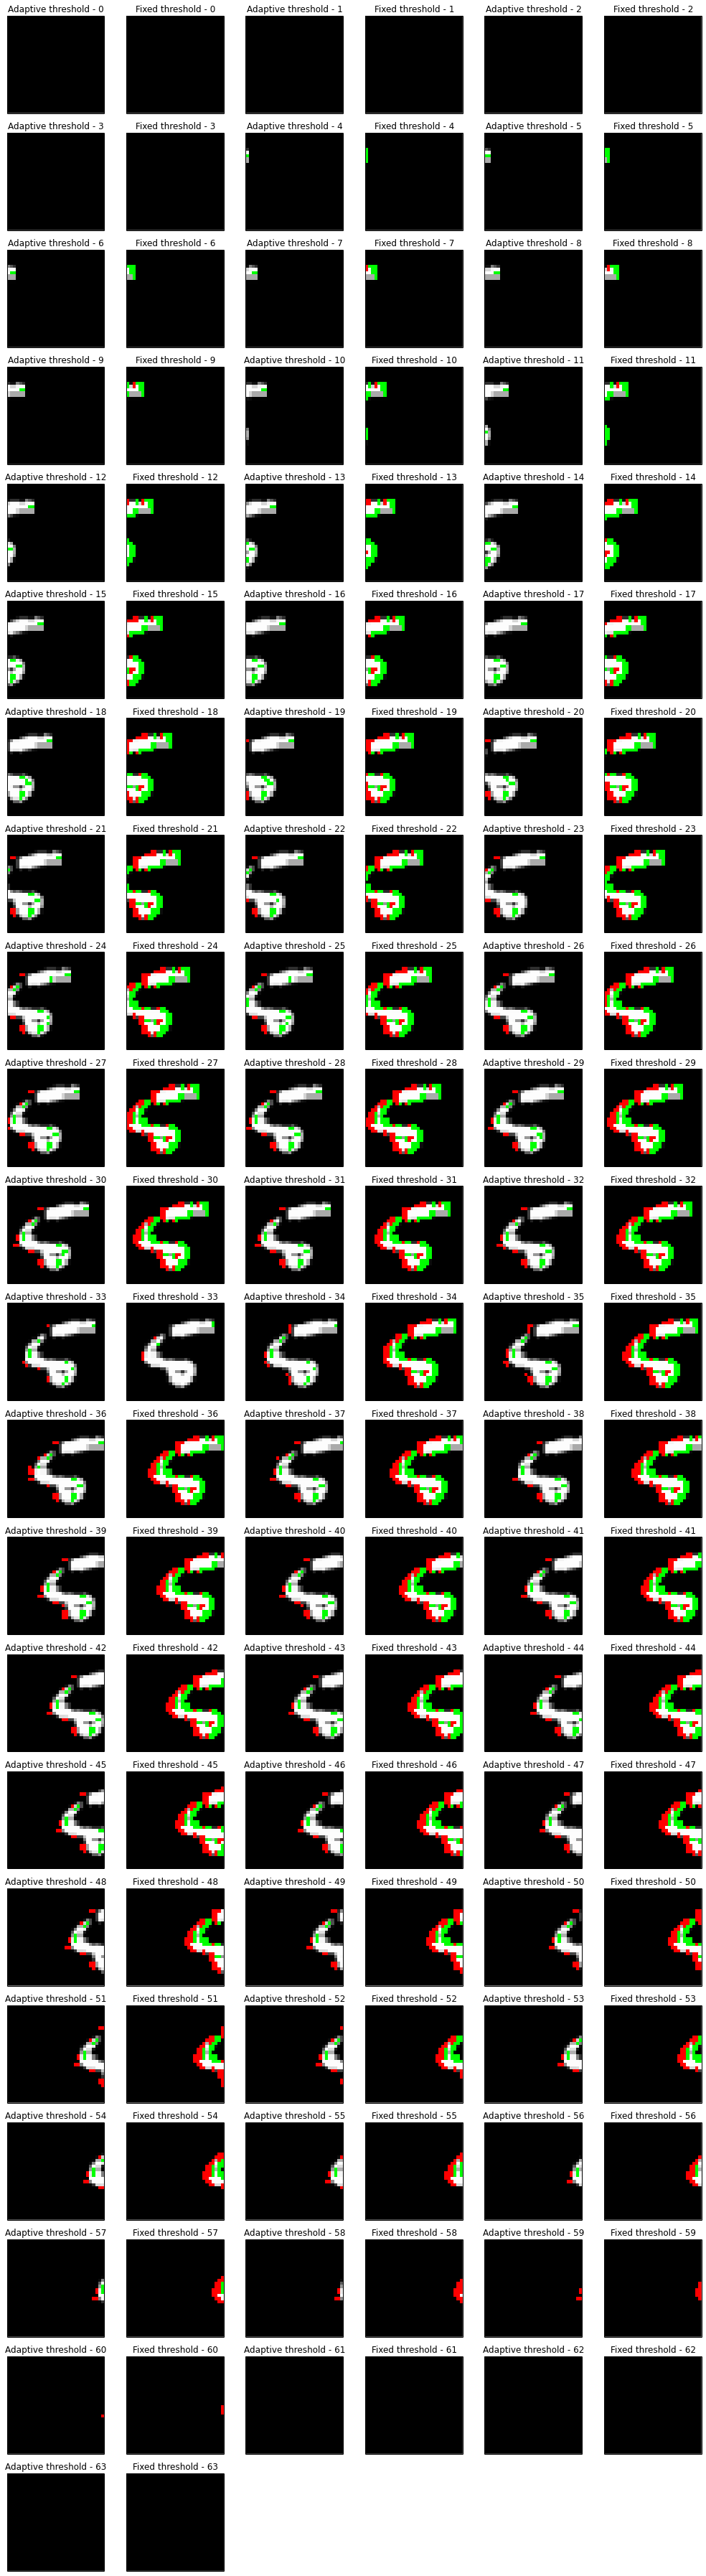

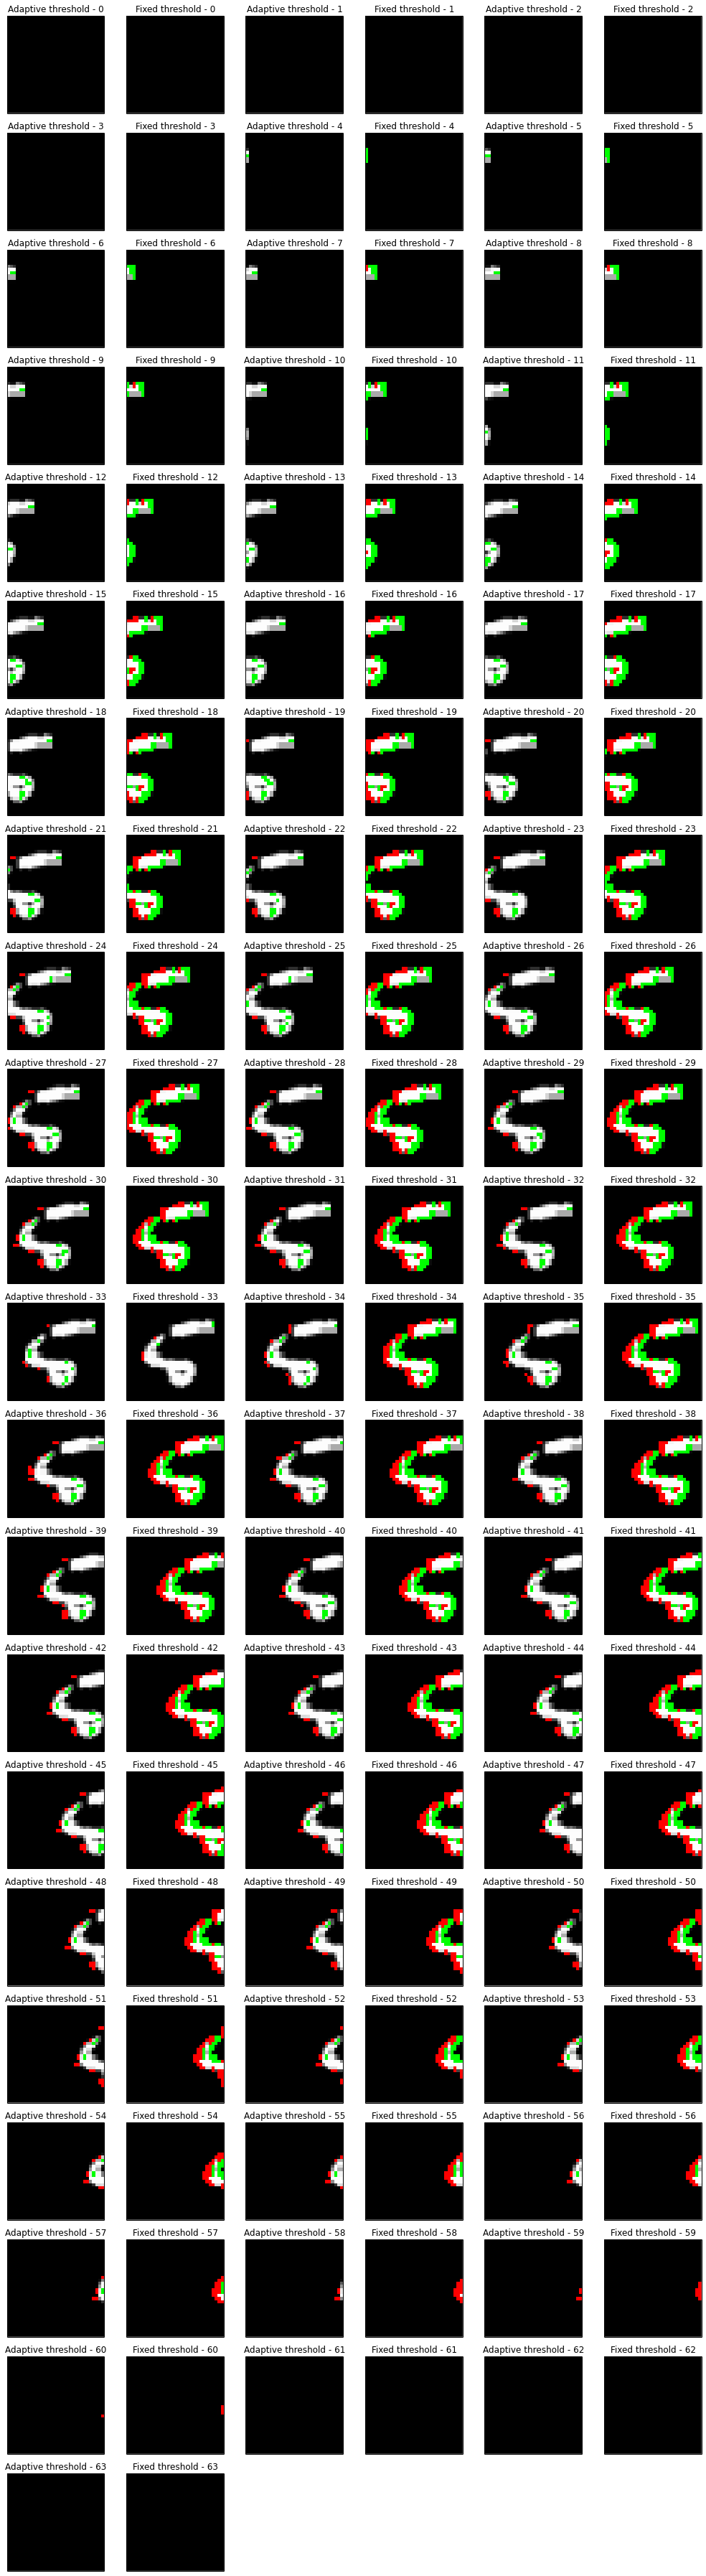

In [70]:
num_frames = int(2*out_w/speed)
num_cols = 6
num_rows = (num_frames//num_cols + 1)*2
fig_w = 2.9
rows = []
cols = []
ref_img[:] = ref_init
ref_img1[:] = ref_init
adp_thr[:] = thr_init
for j in range(5):
    fig = pylab.figure(figsize=(num_cols*fig_w, num_rows*fig_w))
    for i in range(num_frames):
        out_img[:] = traverse_image(ctr_img, i, speed, 0)

        dif_img[:], abs_dif[:], spikes[:] = thresholded_difference_adpt(out_img, ref_img, adp_thr,
                                                                        min_thr, max_thr)

        ref_img[:], adp_thr[:] = update_reference_rate_adpt(abs_dif, spikes, ref_img, adp_thr,
                                                            min_thr, max_thr,
                                                            thr_delta_dn, thr_delta_up,
                                                            frame_time_ms, history_weight)

        dif_img1[:], abs_dif1[:], spikes1[:] = thresholded_difference(out_img, ref_img1, min_thr)

        ref_img1[:] = update_reference_rate(abs_dif1, spikes1, ref_img1,
                                            min_thr, frame_time_ms, history_weight)


        ax = pylab.subplot(num_rows, num_cols, 2*i + 1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title('Adaptive threshold - %s'%(i))
        spk_img[:] = convertColor(out_img.astype(uint8), COLOR_GRAY2RGB)/255.
        rows[:], cols[:] = np.where(spikes < 0)
        spk_img[rows, cols, :] = red
        rows[:], cols[:] = np.where(spikes > 0)
        spk_img[rows, cols, :] = green

        pylab.imshow(spk_img.copy(), interpolation='none')


        ax = pylab.subplot(num_rows, num_cols, 2*i + 2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title('Fixed threshold - %s'%(i))

        spk_img[:] = convertColor(out_img.astype(uint8), COLOR_GRAY2RGB)/255.
        rows[:], cols[:] = np.where(spikes1 < 0)
        spk_img[rows, cols, :] = red
        rows[:], cols[:] = np.where(spikes1 > 0)
        spk_img[rows, cols, :] = green

        pylab.imshow(spk_img.copy(), interpolation='none')

    pylab.show()




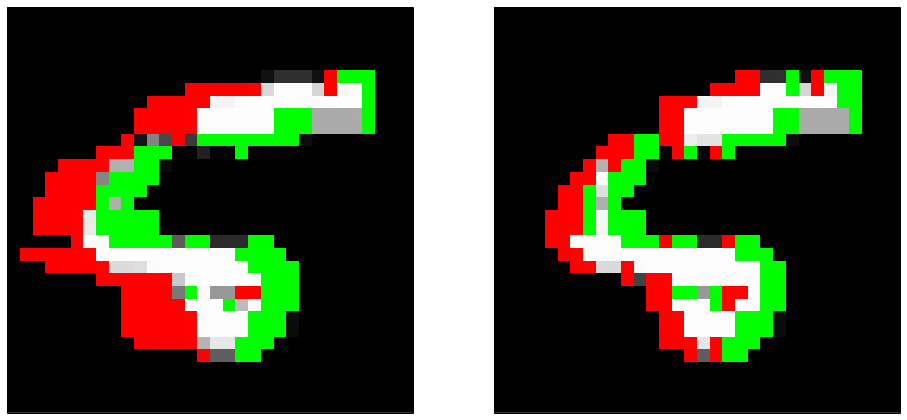

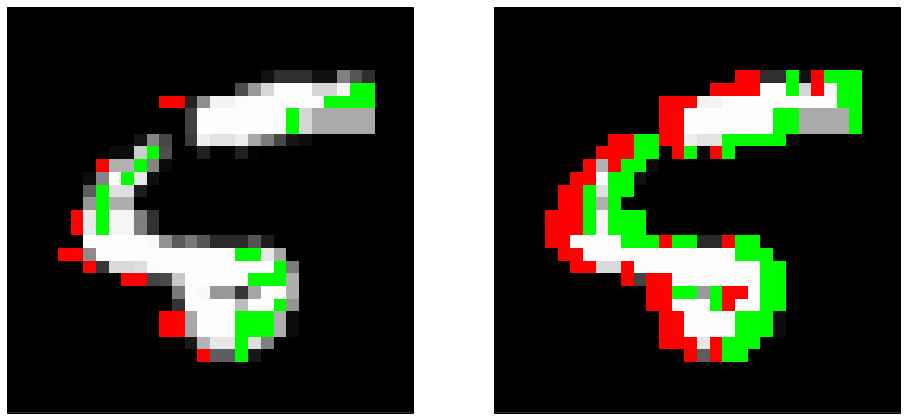

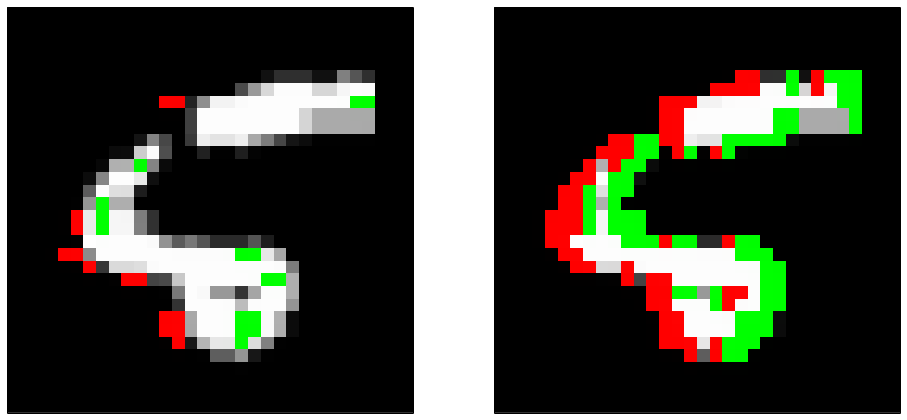

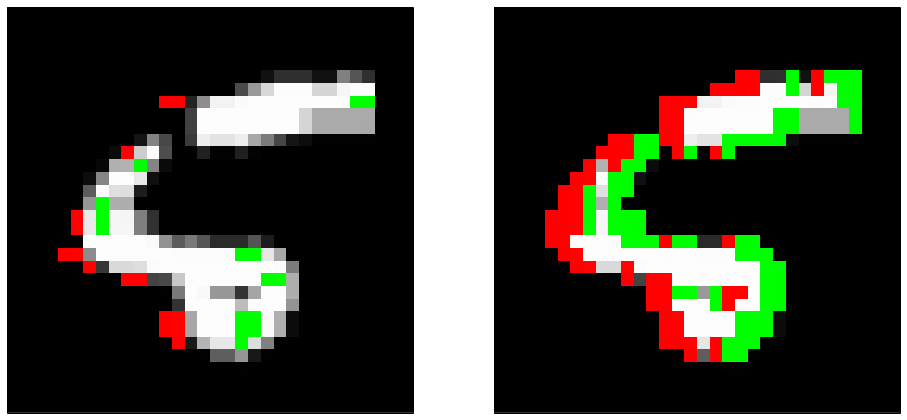

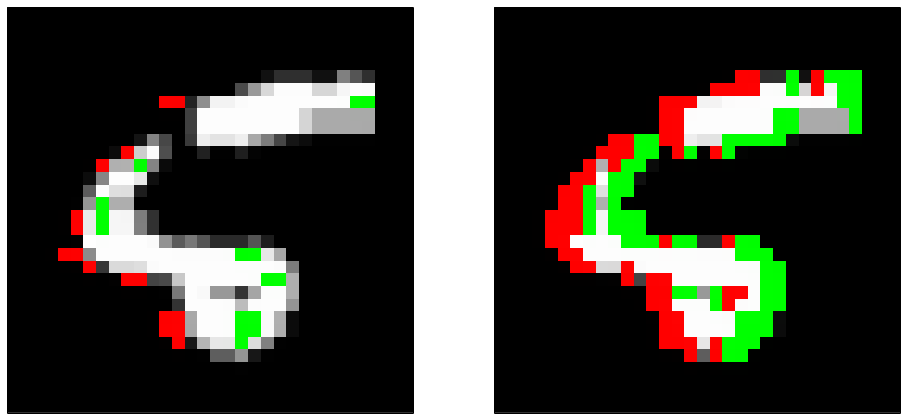

In [71]:
num_frames = int(2*out_w/speed)
num_cols = 2
num_rows = 1
fig_w = 8.
fig = pylab.figure(figsize=(num_cols*fig_w, num_rows*fig_w))
rows = []
cols = []
frame_to_capture = 32
ref_img[:] = ref_init
ref_img1[:] = ref_init
adp_thr[:] = thr_init
for j in range(5):
    fig = pylab.figure(figsize=(num_cols*fig_w, num_rows*fig_w))

    for i in range(num_frames):
        out_img[:] = traverse_image(ctr_img, i, speed, 0)

        dif_img[:], abs_dif[:], spikes[:] = thresholded_difference_adpt(out_img, ref_img, adp_thr,
                                                                        min_thr, max_thr)

        ref_img[:], adp_thr[:] = update_reference_rate_adpt(abs_dif, spikes, ref_img, adp_thr,
                                                            min_thr, max_thr,
                                                            thr_delta_dn, thr_delta_up,
                                                            frame_time_ms, history_weight)

        dif_img1[:], abs_dif1[:], spikes1[:] = thresholded_difference(out_img, ref_img1, min_thr)

        ref_img1[:] = update_reference_rate(abs_dif1, spikes1, ref_img1,
                                            min_thr, frame_time_ms, history_weight)


        if i == frame_to_capture:
            ax = pylab.subplot(num_rows, num_cols, 1)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
    #         ax.set_title('Adaptive threshold - %s'%(i))
            spk_img[:] = convertColor(out_img.astype(uint8), COLOR_GRAY2RGB)/255.
            rows[:], cols[:] = np.where(spikes < 0)
            spk_img[rows, cols, :] = red
            rows[:], cols[:] = np.where(spikes > 0)
            spk_img[rows, cols, :] = green

            pylab.imshow(spk_img.copy(), interpolation='none')


            ax = pylab.subplot(num_rows, num_cols, 2)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
    #         ax.set_title('Fixed threshold - %s'%(i))

            spk_img[:] = convertColor(out_img.astype(uint8), COLOR_GRAY2RGB)/255.
            rows[:], cols[:] = np.where(spikes1 < 0)
            spk_img[rows, cols, :] = red
            rows[:], cols[:] = np.where(spikes1 > 0)
            spk_img[rows, cols, :] = green

            pylab.imshow(spk_img.copy(), interpolation='none')

    pylab.savefig("adaptive_threshold___cycle_%05d___frame_%05d_.png"%(j, i), dpi=1200)
    pylab.show()